In [ ]:
%matplotlib inline

In [ ]:
# !python3 -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [1]:
# basic libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

from IPython import display
import PIL


# detectron2 utilities
import detectron2

from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from k12libs.utils.nb_easy import k12ai_get_top_dir

from detectron2.data.datasets import register_coco_instances

In [ ]:
detectron2.__version__

In [ ]:
prefix = '/data/datasets/cv/'

# register dataset
try:
    register_coco_instances("plates", {}, f"{prefix}/plates_coco/annotations.json", f"{prefix}/plates_coco/")
except:
    pass

plates_metadata = MetadataCatalog.get("plates")
dataset_dicts = DatasetCatalog.get("plates")

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import torch, os

cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
)


cfg.DATASETS.TRAIN = ("plates",)
cfg.DATASETS.TEST = ()   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.OUTPUT_DIR = '/data/nb_data/cv/det/plates/'

# initialize model from model zoo
cfg.MODEL.WEIGHTS = "/data/pretrained/cv/model_zoo/R-50.pkl"  
#cfg.MODEL.WEIGHTS = 'output/model_final.pth' 
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.SOLVER.BASE_LR = 0.00025

cfg.SOLVER.MAX_ITER = 10000    
cfg.SOLVER.CHECKPOINT_PERIOD = 500

# we've only one class - plate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
# trainer.train()

In [3]:
prefix = '/data'

# register dataset
try:
    register_coco_instances("ladder", {}, f"{prefix}/ladder/annotations.json", f"{prefix}/ladder/images/train")
except:
    pass

plates_metadata = MetadataCatalog.get("ladder")
dataset_dicts = DatasetCatalog.get("ladder")

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import torch, os

cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
)


cfg.DATASETS.TRAIN = ("ladder",)
cfg.DATASETS.TEST = ()   
cfg.OUTPUT_DIR = '/data/nb_data/cv/det/ladder/'

# initialize model from model zoo
# cfg.MODEL.WEIGHTS = "/data/pretrained/cv/model_zoo/model_final_68b088.pkl"  
cfg.MODEL.WEIGHTS = 'output/model_final.pth' 
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.SOLVER.BASE_LR = 0.00025

cfg.SOLVER.MAX_ITER = 10000    
cfg.SOLVER.CHECKPOINT_PERIOD = 500

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

[08/09 21:50:04 d2.data.datasets.coco]: Loaded 2000 images in COCO format from /data/ladder/annotations.json


In [4]:
def cv2_imshow(np_img, scale=1.0):
    np_img = np_img.clip(0, 255).astype('uint8')
    if np_img.ndim == 3:
        if np_img.shape[2] == 4:
            np_img = cv2.cvtColor(np_img, cv2.COLOR_BGRA2RGBA)
        else:
            np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)
    pil_img = PIL.Image.fromarray(np_img)
    if scale != 1.0:
        pil_img = pil_img.resize((math.ceil(scale*pil_img.width), math.ceil(scale*pil_img.height)))
    display.display(pil_img)

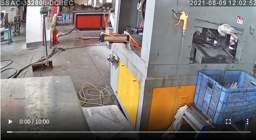

((350, 638, 3), None)

In [9]:
# img = cv2.imread('/data/datasets/cv/CCPD2019/ccpd_rotate/0500-21_15-214&373_445&554-436&554_214&467_223&373_445&460-0_0_6_5_29_24_33-132-78.jpg')
# img = cv2.imread('/data/datasets/cv/licenseplates/images/105zx.jpg')
img = cv2.imread('/data/datasets/cv/plates_coco/JPEGImages/vodec_0206.jpg')

img.shape, cv2_imshow(img, scale=0.4)

In [16]:
outputs = predictor(img)
print(outputs, len(outputs['instances']))
print(type(outputs['instances'].pred_boxes))

{'instances': Instances(num_instances=10, image_height=347, image_width=641, fields=[pred_boxes: Boxes(tensor([[244.4415, 117.9090, 285.7656, 165.3458],
        [467.5970,  73.8289, 512.9739, 123.4042],
        [220.6609, 207.1128, 345.5210, 245.6251],
        [351.7736, 135.5109, 424.9400, 222.0444],
        [233.6593, 251.2758, 440.4163, 331.4370],
        [216.3424,  24.9319, 274.6794,  95.8980],
        [  5.2907, 109.2301,  64.1939, 135.6670],
        [246.9702,  87.2691, 281.3998, 116.9481],
        [606.6516, 122.6810, 628.8273, 134.9642],
        [212.9899, 202.8637, 350.4146, 287.4682]], device='cuda:0')), scores: tensor([0.9871, 0.9831, 0.9658, 0.9615, 0.9355, 0.9306, 0.9070, 0.8778, 0.8773,
        0.8225], device='cuda:0'), pred_classes: tensor([1, 1, 0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')])} 10
<class 'detectron2.structures.boxes.Boxes'>


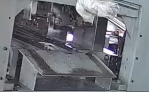

In [11]:
boxes = outputs['instances'].pred_boxes.tensor.to('cpu').numpy()[0]
x0, y0, x1, y1 = [math.ceil(z) for z in boxes]
crop_img = img[y0:y1, x0:x1]
cv2_imshow(crop_img)

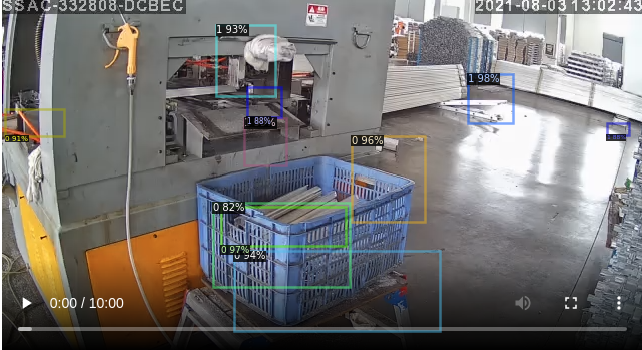

In [18]:
v = Visualizer(
    img[:, :, ::-1],
    scale=1., 
    instance_mode=ColorMode.IMAGE
)
v = v.draw_instance_predictions(outputs['instances'].to('cpu'))

result = v.get_image()
PIL.Image.fromarray(result)